<a href="https://colab.research.google.com/github/uni-3/ml-at-work-exercise/blob/master/notebooks/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### uplift model実データ
p 205

In [0]:
# download data
import urllib.request
csv_url = 'http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv'
csv_filename = 'source_data.csv'

with open(csv_filename, 'w') as f:
    data = urllib.request.urlopen(csv_url).read()
    f.write(data.decode('ascii'))

In [0]:
import pandas as pd

In [0]:
# 男性向けメールを送るか女性向けメールを送るか判定する
# メールのセグメントと属性、購入したかのデータ
df_raw = pd.read_csv(csv_filename)
df_raw.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [0]:
# メールのカテゴリについて判定するのでメールを送っていないデータは外す
df_mailed = df_raw[df_raw['segment'] != 'No E-Mail']
df_mailed = df_mailed.reset_index(drop=True)
df_mailed.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0


In [0]:
df_mailed.shape

(42694, 12)

In [0]:
# カテゴリ変数をダミー変数にする
df_dummied = pd.get_dummies(
    df_mailed[['zip_code', 'channel']], drop_first=True
)

# 不要な列は削除
df_feature_vector = df_mailed.drop(['history_segment', 'zip_code', 'channel'
                                                                , 'segment', 'visit', 'conversion', 'spend'], axis=1)

df_feature_vector = df_feature_vector.join(df_dummied)
df_feature_vector.head()

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0
1,7,180.65,0,1,1,1,0,0,1
2,9,675.83,1,0,1,0,0,0,1
3,2,45.34,1,0,0,0,1,0,1
4,6,134.83,0,1,0,1,0,1,0


In [0]:
# 男性向けメールをtreatとする
# サイト訪問をcvとする
is_treat_list = list(df_mailed['segment'] == 'Mens E-Mail')
is_cv_list = list(df_mailed['visit'] == 1)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# 各データを半分つ
train_is_cv_list, test_is_cv_list, train_is_treat_list, \
test_is_treat_list, df_train_feature_vector, df_test_feature_vector = \
    train_test_split(is_cv_list, is_treat_list, df_feature_vector, test_size=0.5, random_state=42)

df_train_feature_vector = df_train_feature_vector.reset_index(drop=True)
df_test_feature_vector = df_test_feature_vector.reset_index(drop=True)

In [0]:
df_train_feature_vector.shape

(21347, 9)

In [0]:
# train
train_sample_num = len(train_is_cv_list)

treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(train_sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(df_train_feature_vector.loc[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(df_train_feature_vector.loc[i])
      

In [0]:
from sklearn.linear_model import LogisticRegression


In [0]:
treat_model = LogisticRegression(C=0.01,  max_iter=200, solver='lbfgs') # in 0.22 changed to 'lbfgs'
control_model = LogisticRegression(C=0.01,  max_iter=200, solver='lbfgs')

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# test 
test_sample_num = len(test_is_cv_list)

treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(test_sample_num):
    if test_is_treat_list[i]:
        treat_is_cv_list.append(test_is_cv_list[i])
        treat_feature_vector_list.append(df_test_feature_vector.loc[i])
    else:
        control_is_cv_list.append(test_is_cv_list[i])
        control_feature_vector_list.append(df_test_feature_vector.loc[i])
      

In [0]:
# cvを予測
treat_score = treat_model.predict_proba(treat_feature_vector_list)
control_score = control_model.predict_proba(control_feature_vector_list)

print('treat', len(treat_score), 'control', len(control_score))

treat 10583 control 10764


In [0]:
# uplift modelのスコア算出
# クラスの所属確率、1列目(コンバージョンした率)を使う
# スコアが高いと、実験群のCVRが良く（高い）、統制群のCVR悪い（低い）、介入効果があると言える、低いとその逆
len_score = min(len(treat_score), len(control_score))
score_list = treat_score[:len_score, 1] / control_score[:len_score, 1]
score_list

array([1.11754044, 1.45904351, 1.30049082, ..., 0.51339794, 1.53146356,
       2.19444033])

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')
%matplotlib inline

In [0]:
# スコア降順に並べ替え
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

result

In [0]:
# 10%ごとにカウント
qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 10%ごとに取り出す
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    # controlとtreatの数を数える
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    
    # CV数を数える
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)
    
    # CVRに変換、dfに入れる
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%-{}%".format(n * 10, (n+1) * 10)
    qdf.loc[label] = (treat_cvr, control_cvr)

In [0]:
qdf.head()

,treat_cvr,control_cvr
0%-10%,0.173585,0.132827
10%-20%,0.196000,0.136445
20%-30%,0.202756,0.153005
30%-40%,0.208589,0.165202
40%-50%,0.155431,0.145315


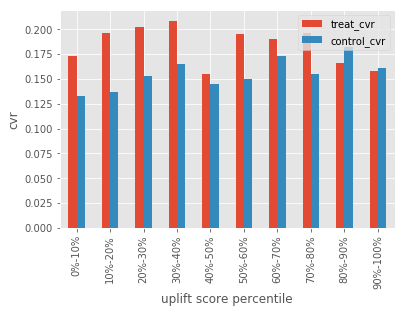

In [0]:
# スコアが高い人(左の方)に介入した方がコンバージョンあげやすいと言える
# この実験では男性向けメールを送る＝実験群なので
# 80%までは男性向けメールを送った方が良い
# 80-100%には女性向けメールの方がいいと言える
qdf.plot.bar()
plt.xlabel('uplift score percentile')
plt.ylabel('cvr')
plt.show()

In [0]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
        
    # liftの算出
    # 実験群がどれくらいの人数コンバージョンを変化させたか
    lift = (treat_cvr - control_cvr) * treat_uu
    
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu,
                     treat_cv, control_cv, treat_cvr, control_cvr, lift])

df = pd.DataFrame(stat_data)

df.columns = [
    'is_cv', 'is_treat', 'score', 'treat_uu', 'control_uu'
    , 'treat_cv', 'control_cv', 'treat_cvr', 'control_cvr', 'lift'
]

# base lineを加える liftの終点についてデータの長さで割った数が各点になる
df['base_line'] = df.index * df['lift'][len(df.index) - 1] / len(df.index)

df.tail()

,is_cv,is_treat,score,treat_uu,control_uu,treat_cv,control_cv,treat_cvr,control_cvr,lift,base_line
10578,False,True,0.394748,5241,5338,963,831,0.183744,0.155676,147.100599,148.024976
10579,True,True,0.389830,5242,5338,964,831,0.183899,0.155676,147.944923,148.038969
10580,False,False,0.384137,5242,5339,964,831,0.183899,0.155647,148.097771,148.052963
10581,False,False,0.329377,5242,5340,964,831,0.183899,0.155618,148.250562,148.066956
10582,False,True,0.302743,5243,5340,964,831,0.183864,0.155618,148.094944,148.080950


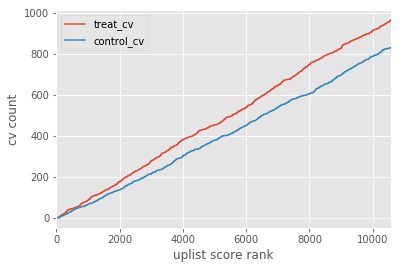

In [0]:
df.plot(y=['treat_cv', 'control_cv'],)
plt.xlabel('uplist score rank')
plt.ylabel('cv count')
plt.show()

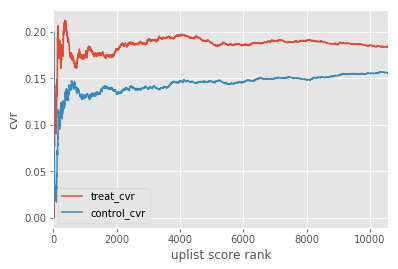

In [0]:
df.plot(y=['treat_cvr', 'control_cvr'],)
plt.xlabel('uplist score rank')
plt.ylabel('cvr')
plt.show()

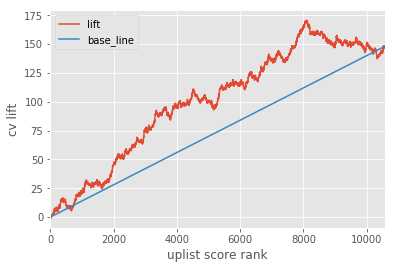

In [0]:
# スコア高い順なので、最後の方は、統制群が勝ち、cv liftは下がる
df.plot(y=['lift', 'base_line'],)
plt.xlabel('uplist score rank')
plt.ylabel('cv lift')
plt.show()

In [0]:
auuc = (df['lift'] - df['base_line']).sum() / len(df['lift'])
print('AUUC:', auuc)

AUUC: 25.96371364202987


In [0]:
df_feature_vector[['mens', 'womens']].count()

mens      42694
womens    42694
dtype: int64